In [1]:
#import/install all packages at the top

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
# import base64
# import string
# import re
from collections import Counter
from spacy.lang.en.stop_words import STOP_WORDS
import string

In [2]:
#import and read file in df with pandas (for better visualisation)

filename= "/Users/laure/OneDrive/Dokumente/VU/Python for Text Analysis/Final Assignment/irony-labeled.csv"

df = pd.read_csv(filename)

In [3]:
#rename the columns
df.columns = ["Comment_Text", "Label"]
df.head()

,Comment_Text,Label
0,I suspect atheists are projecting their desire...,-1
1,It's funny how the arguments the shills are ma...,-1
2,We are truly following the patterns of how the...,-1
3,air pressure dropping as altitude goes higher....,-1
4,Absolutely. I think we'd be hard pressed to f...,-1


In [4]:
#checking for any missing values
missing_data = df.isnull().sum()
missing_data

Comment_Text    0
Label           0
dtype: int64

In [5]:
print("This Irony dataset entails", len(df), "items")

This Irony dataset entails 1949 items


In [6]:
#Count number of ironic (1) and non-ironic (-1) comments in data

ironic = []
non_ironic = []

for x in df["Label"]:
    if x == 1:
        ironic.append(x)
    else:
        non_ironic.append(x)

print(f"The dataset enails a total of {len(ironic)} IRONIC comments")
print(f"The dataset enails a total of {len(non_ironic)} NON-IRONIC comments")

The dataset enails a total of 537 IRONIC comments
The dataset enails a total of 1412 NON-IRONIC comments


# Split into Train (70), Validation (10) and Test (20) sets

-using scikit learn 'train_test_split' function twices gives the validation set

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
y = df["Comment_Text"]
x = df["Label"]

#think this is the right way round.... !! 
#i.e. x = label, y = comment, but we may need to check haha

##double check and see top 5
# print(x.head())
# print(y.head())

In [9]:
#test and train sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=13)

#split the training set to get validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.125, random_state=13)

#pandas concat joins series together (i.e. dataframes)
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)
val = pd.concat([X_val, y_val], axis=1)

print("The Train set entails:", len(train), "items") #70
print("The Test set entails:", len(test), "items")  #20
print("This Validation set entails:", len(val), "items")   #10

The Train set entails: 1364 items
The Test set entails: 390 items
This Validation set entails: 195 items


In [10]:
# ##Indexing Training - comment
# "Comment_label:", train["Comment_Text"].iloc[:4]

In [11]:
# ##Indexing Training - label
# "Label:", train["Label"].iloc[:4]

In [12]:
# pandas '.shape' to see dataframe in form of tuples (no. of rows / cols)

print("Training Data Shape:", train.shape)
print("Testing Data Shape:", test.shape)
print("Validation Data Shape:", val.shape)

Training Data Shape: (1364, 2)
Testing Data Shape: (390, 2)
Validation Data Shape: (195, 2)


# Summaries of the distribution of comments by both labels (i.e. non-ironic = -1, ironic = 1)

- use matplotlib to create THREE bar charts for visualisation for each of the sets:
        (1) Train
        (2) Validation
        (3) Test

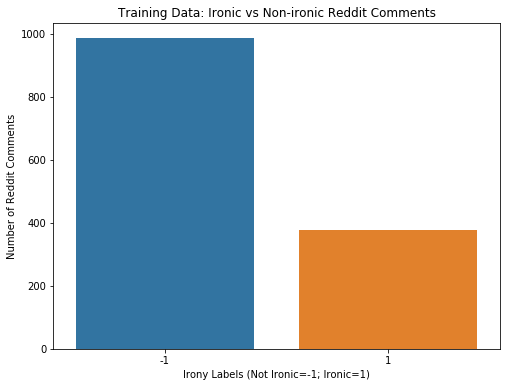

In [13]:
#TRAIN

fig = plt.figure(figsize=(8,6))
sns.barplot(x = train["Label"].unique(), 
            y=train["Label"].value_counts())

plt.title("Training Data: Ironic vs Non-ironic Reddit Comments")
plt.ylabel("Number of Reddit Comments")
plt.xlabel("Irony Labels (Not Ironic=-1; Ironic=1)")
plt.show()

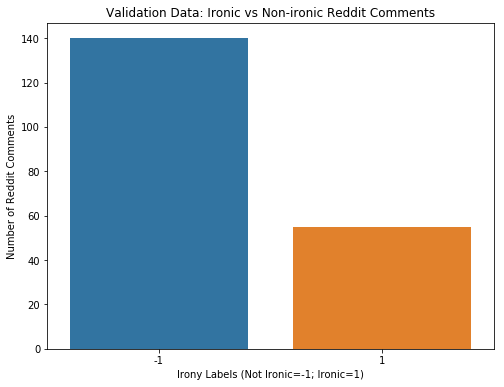

In [14]:
#VALIDATION

fig = plt.figure(figsize=(8,6))
sns.barplot(x = val["Label"].unique(), 
            y=val["Label"].value_counts())

plt.title("Validation Data: Ironic vs Non-ironic Reddit Comments")
plt.ylabel("Number of Reddit Comments")
plt.xlabel("Irony Labels (Not Ironic=-1; Ironic=1)")
plt.show()

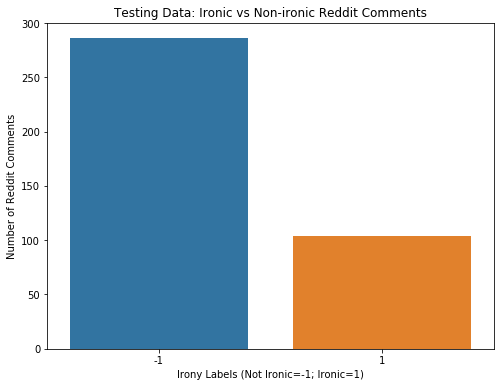

In [15]:
#TEST

fig = plt.figure(figsize=(8,6))
sns.barplot(x = test["Label"].unique(), 
            y=test["Label"].value_counts())

plt.title("Testing Data: Ironic vs Non-ironic Reddit Comments")
plt.ylabel("Number of Reddit Comments")
plt.xlabel("Irony Labels (Not Ironic=-1; Ironic=1)")
plt.show()

In [16]:
#check format of train df

train.head()

,Label,Comment_Text
544,-1,What makes you think Warren isn't Obama V 2. 0...
1462,1,It surprises me that Republican congressmen us...
976,-1,"His favorite color is Coca Cola, he clearly kn..."
372,-1,That's hilarious.
1350,1,"Only to keep them from being embarrassed, beca..."


# CHANGES FROM 20/01/2019 -
see below - stuff before deleted to follow the converting to string method we chatted about...

# Split train set into "Ironic" and "Not-ironic" dataframes, then convert each into strings 
- converting after into strings for easier parsing with SpaCy

In [17]:
#Split the training set into Ironic and Not ironic, making 2 new dataframes, with same headers
ironic_df = train[train["Label"] >= 1]
nonironic_df = train[train["Label"] <= -1]

print(f"Training data contains {len(ironic_df)} IRONIC comments")
print(f"Training data contains {len(nonironic_df)} NON- IRONIC comments")

Training data contains 378 IRONIC comments
Training data contains 986 NON- IRONIC comments


In [18]:
def convert_to_string(df_with_columnname):
    """Convert column of a dataframe into a string - remove headers and index and return entire string"""
    return df_with_columnname.to_string(index=False)

In [19]:
#convert both dfs to strings
ironic_train_str = convert_to_string(ironic_df["Comment_Text"])
nonironic_train_str = convert_to_string(nonironic_df["Comment_Text"])

#print(repr(ironic_train_str))
#print(repr(notironic_train_str))

# Parse through SpaCy to get STATS:

-----Create list of functions for each:
- average word length
- average sentence length
- number of word types

In [20]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [21]:
def nlp_convert(text):
    """Parse text with SpaCy"""
    doc = nlp(text)
    return doc

In [22]:
def average_word_length(doc):
    """Take doc and return average word length"""
    for token in doc:
        word = token.text
        average_word_length = sum(len(word) for word in doc) / len(doc)
    return(average_word_length)

def average_sent_length(doc):
    """Take doc and return average sentence length"""
    sent_list = []

    for sent in doc.sents:
        len_sent = len(sent)
        sent_list.append(len_sent)

    total = sum(sent_list)
    leng = len(sent_list)

    average_sent_length = total / leng
    return(average_sent_length)

In [23]:
def relative_count_wordtypes(doc):
    pos_tags = []
    for token in doc:
        pos_tags.append(token.pos_)
    return Counter(pos_tags)

# IRONIC RETURNS:

In [24]:
#parse through spacy
ir_doc = nlp_convert(ironic_train_str)

#average stats (word & sent)
ir_average_wordlen = average_word_length(ir_doc)
ir_average_sentlength = average_sent_length(ir_doc)

#word type stats
ir_count_wordtypes = relative_count_wordtypes(ir_doc)

print(f"Average Word Length for the Ironic Corpus is: {ir_average_wordlen}")
print(f"Average Sentence Length for the Ironic Corpus is: {ir_average_sentlength}") 
print(f"Relative Count of Word Types for the Ironic Corpus is: \n {ir_count_wordtypes}")

Average Word Length for the Ironic Corpus is: 3.732196358607974
Average Sentence Length for the Ironic Corpus is: 9.816742081447964
Relative Count of Word Types for the Ironic Corpus is: 
 Counter({'PUNCT': 699, 'VERB': 689, 'NOUN': 564, 'SPACE': 459, 'DET': 315, 'ADP': 285, 'PRON': 280, 'ADJ': 280, 'ADV': 252, 'PROPN': 244, 'PART': 80, 'CCONJ': 79, 'INTJ': 44, 'NUM': 36, 'X': 22, 'SYM': 11})


# NON-IRONIC RETURNS:

In [25]:
#parse through spacy
non_ir_doc = nlp_convert(nonironic_train_str)

#average stats (word & sent)
non_ir_average_wordlen = average_word_length(non_ir_doc)
non_ir_average_wordlen = average_sent_length(non_ir_doc)

#word type stats
non_ir_count_wordtypes = relative_count_wordtypes(non_ir_doc)

print(f"Average Word Length for the Non-ironic Corpus is: {non_ir_average_wordlen}")
print(f"Average Sentence Length for the Non-ironic Corpus is: {non_ir_average_wordlen}") 
print(f"Relative Count of Word Types for the Non-ironic Corpus is: \n {non_ir_count_wordtypes}")


Average Word Length for the Non-ironic Corpus is: 9.435215946843854
Average Sentence Length for the Non-ironic Corpus is: 9.435215946843854
Relative Count of Word Types for the Non-ironic Corpus is: 
 Counter({'VERB': 1863, 'PUNCT': 1808, 'NOUN': 1516, 'SPACE': 1217, 'DET': 898, 'PRON': 790, 'ADV': 743, 'ADP': 712, 'ADJ': 670, 'PROPN': 540, 'CCONJ': 210, 'PART': 161, 'NUM': 90, 'INTJ': 62, 'X': 45, 'SYM': 35})


# SpaCy Continued: Text Processing 

- stopwords, punctuation, lemmatize

- (need to run named entity recognition AND sentiment analysis)

[sentiment analysis - ironic ones should typically be more negative....]


In [26]:
stopwords = list(STOP_WORDS)
stopwords

['does',
 'no',
 'go',
 'have',
 'at',
 'besides',
 'seeming',
 'since',
 'such',
 'through',
 'former',
 'but',
 'eleven',
 'nothing',
 'anywhere',
 'serious',
 'my',
 'whither',
 'third',
 'your',
 'thereby',
 'themselves',
 'unless',
 'his',
 'often',
 'call',
 'being',
 'thus',
 'further',
 'take',
 'ours',
 'when',
 'those',
 'both',
 'give',
 'hundred',
 'forty',
 'nine',
 'beforehand',
 'out',
 'almost',
 'noone',
 'something',
 'not',
 'throughout',
 'what',
 'wherein',
 'nobody',
 'name',
 'otherwise',
 'our',
 'ever',
 'regarding',
 'why',
 'whoever',
 'yourselves',
 'alone',
 'now',
 'for',
 'via',
 'that',
 'indeed',
 'somehow',
 'front',
 'less',
 'they',
 'already',
 'onto',
 'become',
 'afterwards',
 'none',
 'still',
 'within',
 'various',
 'whereupon',
 'becoming',
 'eight',
 'down',
 'upon',
 'due',
 'two',
 'hers',
 'cannot',
 'hereupon',
 'mine',
 'with',
 'three',
 'their',
 'could',
 'and',
 'see',
 'thru',
 'even',
 'everywhere',
 'he',
 'any',
 'more',
 'twenty'

In [28]:
import string
punctu = string.punctuation
punctu

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# #Get the LEMMA

# for word in 